In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import datetime
import yfinance as yf
import networkx as nx

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'V', 'PG', 'KO', 'WMT', 'PEP', 'CVX', 'XOM', 'SLB', 'BA', 'UPS', 'CAT', 'MMM', 'JNJ', 'PFE', 'MRNA', 'DIS', 'NFLX', 'T', 'NVDA', 'ORCL', 'INTC', 'LMT', 'GS', 'COST', 'BTC-USD', 'ETH-USD', 'LTC-USD', 'XRP-USD']

# Get Dataset

In [3]:
def get_dataset(year,portfolio):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    data = yf.download(portfolio, start=start_date, end=end_date)['Adj Close'].dropna()
    
    return data

In [4]:
def calculate_average_clustering(year,tickers=tickers):
    dataset=get_dataset(year,tickers).pct_change().dropna()
    corr=dataset.corr()
    adjacency=corr.values
    
    threshold=np.mean(adjacency)
    
    for i in range(35):
        for j in range(35):
            if adjacency[i,j]<threshold:
                adjacency[i,j]=0
    
    #threshold network
    network=nx.from_numpy_matrix(adjacency)
    
    tickers=corr.columns.tolist()
    mapping = dict(zip(network.nodes, tickers))
    network = nx.relabel_nodes(network, mapping)
    
    clustering_dict = nx.clustering(network)
    
    return clustering_dict

In [5]:
def dataset_parameters(year,stockFileName):
    
    #dataset
    originalRows=35
    data = pd.read_csv(stockFileName,  nrows= originalRows,index_col=['assets'])
    
    #columns
    assetLabels = data.columns.tolist()
    
    #covariance
    dfStockPrices = data
    assetParameters=np.array(dfStockPrices)
    
    return assetLabels,assetParameters

In [6]:
def show_wcss(year,stockFileName):
    
    _,assetParameters=dataset_parameters(2020,stockFileName)
    
    #WCSS
    wcss = []
    for i in range(1, 35):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(assetParameters )
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 35), wcss, label=f'{year} WCSS plot')
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.legend()
    plt.show()

In [7]:
def kmeans_clustering(year,stockFileName,clusternumber):
    
    assetLabels,assetParameters=dataset_parameters(year,stockFileName)
    
    #Kmeans clustering
    kmeans= KMeans(algorithm='auto',  max_iter=600, n_clusters=clusternumber)
    
    kmeans.fit(assetParameters)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

   
    assets = np.array(assetLabels)
    cluster_list=[]
    for i in range(clusternumber):
        print('Cluster', i+1)
        clt  = np.where(labels == i)
        assetsCluster = assets[clt]
        print(assetsCluster)
        cluster_list.append(assetsCluster.tolist());
    
    return cluster_list

# Portfolio with highest mean returns assets

In [8]:
def retReturns(i):
    return meanreturns.get(i)


def portfolio_highest_mean(clusters):
    sorted_list=[]
    for assetList in clusters:
        sorted_list.append(sorted(assetList, key=retReturns,reverse=True))
    
    assets=[]
    for i in sorted_list:
        if len(i)<5:
            assets.extend([j for j in i])
        else:
            assets.extend([j for j in i[0:5]])
                
    return sorted(assets, key=retReturns,reverse=True)[0:7]


# Portfolio with lowest risk assets

In [9]:
def retRisk(i):
    return risk.get(i)


def portfolio_lowest_risk(clusters):
    sorted_list=[]
    for assetList in clusters:
        sorted_list.append(sorted(assetList, key=retRisk,reverse=False))
    
    assets=[]
    for i in sorted_list:
        if len(i)<5:
            assets.extend([j for j in i])
        else:
            assets.extend([j for j in i[0:5]])
    return sorted(assets, key=retReturns,reverse=True)[0:7]


# Portfolio with lowest average clustering coefficient

In [10]:
def retClustering(i):
    return clustering.get(i)


def portfolio_lowest_avg_clustering(clusters):
    sorted_list=[]
    for assetList in clusters:
        sorted_list.append(sorted(assetList, key=retClustering,reverse=False))
    
    assets=[]
    for i in sorted_list:
        if len(i)<5:
            assets.extend([j for j in i])
        else:
            assets.extend([j for j in i[0:5]])
    return sorted(assets, key=retReturns,reverse=True)[0:7]


# Diversification Index- Using Equal Weighted(EW) Portfolio

In [11]:
def diversification_ratio(year,portfolio):
    
    #Download Adjacent closing prices for the selected assets in the portfolio
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    data = yf.download(portfolio, start=start_date, end=end_date)['Adj Close']
    
    #calculating returns
    returns = data.pct_change().dropna()
    
    #calculating volatility (standard deviation)
    volatilities = returns.std() * np.sqrt(251)
    
    #calculating covariance of the returns
    cov_matrix = returns.cov() * 252
    
    #Constructing E.W portfolio
    weights = np.ones(len(data.columns)) / len(data.columns)
    
    #Calculating the weighted sum of individual volatilities
    weighted_vol_sum = np.dot(volatilities, weights)
    
    # Computing the portfolio volatility using the covariance matrix
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
    
    # Calculating the Diversification Ratio
    diversification_ratio = weighted_vol_sum / portfolio_volatility
    
    return diversification_ratio

In [12]:
def diversification_dictionary(year,p1,p2,p3):
    d_d={}
    d_d['highest_return']=diversification_ratio(year,p1)
    d_d['lowest_risk']=diversification_ratio(year,p2)
    d_d['lowest_clustering']=diversification_ratio(year,p3)
    
    return d_d

# Code Execution

## Put relevant variables

In [43]:
year=2023
correlation_matrix = f'./mi_cor_mat_{year}.csv'
meanreturns= dict((get_dataset(year,tickers).pct_change().dropna()).mean())
risk=dict((get_dataset(year,tickers).pct_change().dropna()).std())
clustering=calculate_average_clustering(year)

correlation_method='MI'

[*********************100%%**********************]  35 of 35 completed
[*********************100%%**********************]  35 of 35 completed
[*********************100%%**********************]  35 of 35 completed


## WCSS plot

C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

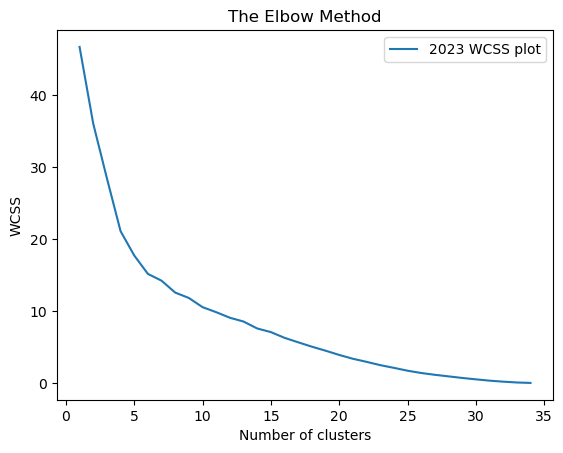

In [44]:
show_wcss(year,correlation_matrix)

## Select Number of clusters

In [45]:
num_clusters=31

## Get the portfolios

In [46]:
portfolio_with_highest_mean=portfolio_highest_mean(kmeans_clustering(year,correlation_matrix,num_clusters))
portfolio_with_lowest_risk=portfolio_lowest_risk(kmeans_clustering(year,correlation_matrix,num_clusters))
portfolio_with_lowest_avg_clustering_coef=portfolio_lowest_avg_clustering(kmeans_clustering(year,correlation_matrix,num_clusters))

C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 1
['INTC']
Cluster 2
['BAC' 'GS']
Cluster 3
['WMT']
Cluster 4
['LTC-USD']
Cluster 5
['MSFT']
Cluster 6
['CVX' 'XOM']
Cluster 7
['KO' 'PEP']
Cluster 8
['PFE']
Cluster 9
['LMT']
Cluster 10
['V']
Cluster 11
['MRNA']
Cluster 12
['T']
Cluster 13
['AAPL']
Cluster 14
['JNJ']
Cluster 15
['DIS']
Cluster 16
['COST']
Cluster 17
['ORCL']
Cluster 18
['BA']
Cluster 19
['NFLX']
Cluster 20
['TSLA']
Cluster 21
['MMM']
Cluster 22
['XRP-USD']
Cluster 23
['AMZN']
Cluster 24
['JPM']
Cluster 25
['UPS']
Cluster 26
['NVDA']
Cluster 27
['CAT']
Cluster 28
['SLB']
Cluster 29
['BTC-USD' 'ETH-USD']
Cluster 30
['GOOGL']
Cluster 31
['PG']


C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 1
['UPS']
Cluster 2
['NFLX']
Cluster 3
['LTC-USD']
Cluster 4
['KO' 'PEP']
Cluster 5
['CVX' 'XOM']
Cluster 6
['JNJ']
Cluster 7
['BAC' 'GS']
Cluster 8
['AMZN']
Cluster 9
['COST']
Cluster 10
['PFE']
Cluster 11
['LMT']
Cluster 12
['T']
Cluster 13
['MRNA']
Cluster 14
['NVDA']
Cluster 15
['ORCL']
Cluster 16
['BA']
Cluster 17
['INTC']
Cluster 18
['V']
Cluster 19
['DIS']
Cluster 20
['TSLA']
Cluster 21
['AAPL']
Cluster 22
['WMT']
Cluster 23
['MMM']
Cluster 24
['BTC-USD' 'ETH-USD']
Cluster 25
['XRP-USD']
Cluster 26
['CAT']
Cluster 27
['JPM']
Cluster 28
['MSFT']
Cluster 29
['SLB']
Cluster 30
['GOOGL']
Cluster 31
['PG']


C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
C:\Users\joydi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 1
['AMZN']
Cluster 2
['BAC' 'GS']
Cluster 3
['KO' 'PEP']
Cluster 4
['LTC-USD']
Cluster 5
['SLB']
Cluster 6
['MRNA']
Cluster 7
['T']
Cluster 8
['COST']
Cluster 9
['JNJ']
Cluster 10
['LMT']
Cluster 11
['DIS']
Cluster 12
['ORCL']
Cluster 13
['INTC']
Cluster 14
['AAPL']
Cluster 15
['BA']
Cluster 16
['PFE']
Cluster 17
['V']
Cluster 18
['NVDA']
Cluster 19
['NFLX']
Cluster 20
['MMM']
Cluster 21
['WMT']
Cluster 22
['TSLA']
Cluster 23
['XRP-USD']
Cluster 24
['UPS']
Cluster 25
['CVX' 'XOM']
Cluster 26
['CAT']
Cluster 27
['MSFT']
Cluster 28
['BTC-USD' 'ETH-USD']
Cluster 29
['JPM']
Cluster 30
['PG']
Cluster 31
['GOOGL']


In [47]:
print(portfolio_with_highest_mean)
print(portfolio_with_lowest_risk)
print(portfolio_with_lowest_avg_clustering_coef)

['NVDA', 'BTC-USD', 'TSLA', 'XRP-USD', 'ETH-USD', 'INTC', 'AMZN']
['NVDA', 'BTC-USD', 'TSLA', 'XRP-USD', 'ETH-USD', 'INTC', 'AMZN']
['NVDA', 'BTC-USD', 'TSLA', 'XRP-USD', 'ETH-USD', 'INTC', 'AMZN']


In [48]:
print((yf.download(portfolio_with_highest_mean, start=f'{year}-01-01', end=f'{year}-12-31')['Adj Close'].pct_change()*100).dropna().mean().sum())
print((yf.download(portfolio_with_lowest_risk, start=f'{year}-01-01', end=f'{year}-12-31')['Adj Close'].pct_change()*100).dropna().mean().sum())
print((yf.download(portfolio_with_lowest_avg_clustering_coef, start=f'{year}-01-01', end=f'{year}-12-31')['Adj Close'].pct_change()*100).dropna().mean().sum())

[*********************100%%**********************]  7 of 7 completed
1.7681067918880515
[*********************100%%**********************]  7 of 7 completed
1.7681067918880515
[*********************100%%**********************]  7 of 7 completed
1.7681067918880515


## Check Diversification Ratio

In [49]:
diversification_dictionary(year,portfolio_with_highest_mean,portfolio_with_lowest_risk,portfolio_with_lowest_avg_clustering_coef)

[*********************100%%**********************]  7 of 7 completed
[*********************100%%**********************]  7 of 7 completed
[*********************100%%**********************]  7 of 7 completed


{'highest_return': 1.6591333713259246,
 'lowest_risk': 1.6591333713259246,
 'lowest_clustering': 1.6591333713259246}

## Download Dataset 

### Dataset constructed of stocks with highest mean

In [50]:
get_dataset(year,portfolio_with_highest_mean).to_csv(f'{correlation_method}_Kmeans_{year}_highest_mean.csv')

[*********************100%%**********************]  7 of 7 completed


### Dataset constructed of stocks with lowest risk

In [51]:
get_dataset(year,portfolio_with_lowest_risk).to_csv(f'{correlation_method}_Kmeans_{year}_lowest_risk.csv')

[*********************100%%**********************]  7 of 7 completed


### Dataset constructed of stocks with lowest average clustering coef

In [52]:
get_dataset(year,portfolio_with_lowest_avg_clustering_coef).to_csv(f'{correlation_method}_Kmeans_{year}_lowest_average_clustering.csv')

[*********************100%%**********************]  7 of 7 completed
